In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
copynumer_df = pd.read_pickle('./processed_data/copynumer_df.pkl')
drugresponse_df = pd.read_pickle('./processed_data/drugresponse_df.pkl')
metabolomics_df = pd.read_pickle('./processed_data/metabolomics_df.pkl')
methylation_df = pd.read_pickle('./processed_data/methylation_df.pkl')
proteomics_df = pd.read_pickle('./processed_data/proteomics_df.pkl')
transcriptomics_df = pd.read_pickle('./processed_data/transcriptomics_df.pkl')
fusions_df = pd.read_pickle('./processed_data/fusions_final_df.pkl')

In [3]:
fusions_df = fusions_df.reset_index()

In [4]:
input_df = (
    fusions_df
    .merge(copynumer_df, left_on='model_id', right_index=True, suffixes=['', '_copynumer'])
    .merge(drugresponse_df, left_on='model_id', right_index=True, suffixes=['', '_drugresponse'])
    .merge(metabolomics_df, left_on='model_id', right_index=True, suffixes=['', '_metabolomics'])
    .merge(methylation_df, left_on='model_id', right_index=True, suffixes=['', '_methylation'])
    .merge(proteomics_df, left_on='model_id', right_index=True, suffixes=['', '_proteomics'])
    .merge(transcriptomics_df, left_on='model_id', right_index=True, suffixes=['', '_transcriptomics'])
)

In [5]:
input_df = input_df.set_index('model_id')

In [6]:
input_df.head()

,fusion_count,in_frame_3UTR_3UTR,in_frame_3UTR_5UTR,in_frame_3UTR_CODING,in_frame_5UTR_5UTR,in_frame_5UTR_CODING,in_frame_No,in_frame_SOMETHING_INTRON,in_frame_Yes,in_frame_ambiguous,...,ZWILCH_transcriptomics,ZWINT_transcriptomics,ZXDA,ZXDB_transcriptomics,ZXDC_transcriptomics,ZYG11A_transcriptomics,ZYG11B_transcriptomics,ZYX_transcriptomics,ZZEF1_transcriptomics,ZZZ3_transcriptomics
model_id,,,,,,,,,,,,,,,,,,,,,
SIDM00046,15,0,0,1,1,3,5,0,4,1,...,5.30791,6.61797,1.60898,3.89132,5.07034,1.43384,4.89578,7.85737,6.32957,5.04573
SIDM00047,2,0,0,1,0,0,1,0,0,0,...,5.77799,6.63569,2.52953,4.19684,4.53901,-0.83239,5.21132,7.02936,5.91940,5.83587
SIDM00048,9,1,0,0,0,0,4,0,3,1,...,5.56682,6.89185,2.52134,4.22761,4.88434,-0.38911,5.10613,7.08207,6.02523,5.65201
SIDM00098,4,0,0,1,0,0,2,0,1,0,...,5.78098,6.65350,2.05654,3.92582,4.89359,-1.52334,5.17720,7.11551,6.26238,5.83334
SIDM00099,1,0,0,0,0,0,1,0,0,0,...,5.81931,6.61506,2.39253,4.15398,4.57227,-0.64660,5.43610,7.44160,6.32660,5.79604


In [7]:
target_df = pd.read_pickle('./processed_data/proteomics_df.pkl')

In [8]:
target_df.head()

,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AARS1,AARS2,AARSD1,AASDHPPT,...,ZNF830,ZNHIT2,ZNRD2,ZNRF2,ZPR1,ZRANB2,ZW10,ZWILCH,ZWINT,ZYX
SIDM00046,3.35516,2.47970,2.64814,3.42747,2.29730,2.79989,5.03959,4.36283,2.83884,3.10565,...,0.94939,1.96832,4.87203,3.54926,2.74466,3.96470,2.31081,1.44500,2.23063,4.87281
SIDM00047,3.47470,1.78254,3.52149,2.92188,1.37197,2.97951,5.14901,3.88597,3.55916,3.35535,...,0.84154,1.78003,3.42515,2.79853,3.20215,4.02278,2.24471,1.87061,1.76904,4.96541
SIDM00048,3.56201,2.52743,3.26977,3.48947,2.15151,2.75366,5.11889,3.51744,3.29552,3.52091,...,1.34557,2.03291,4.14519,3.22756,3.29044,3.98339,2.58220,2.09735,2.47003,4.91925
SIDM00098,3.50973,2.33440,3.43963,3.32111,2.48636,3.17103,5.59721,3.94357,3.56998,4.25737,...,0.81172,1.79803,4.24853,3.12697,3.93978,4.55265,2.63257,1.90050,2.06059,5.91146
SIDM00099,3.54051,2.12653,2.91819,2.84000,2.05342,2.33734,4.71901,3.52292,2.09409,2.49224,...,0.35651,1.80656,3.25177,2.95097,2.55263,3.52448,2.67204,1.77170,1.80426,5.53598


### Test Train Split

In [9]:
indices = input_df.index
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.15, random_state=42)

### Transformer Architecture

In [10]:
class MultiOmicsTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, num_tokens=8, d_model=1024, nhead=4, num_transformer_layers=4, dropout=0.2):
        super().__init__()

        self.num_tokens = num_tokens
        self.d_model = d_model

        self.input_projection = nn.Linear(input_dim, num_tokens * d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True, activation=nn.GELU())
        encoder_norm = nn.LayerNorm(d_model)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers, norm=encoder_norm)
        
        self.head = nn.Sequential(
            nn.Linear(d_model * num_tokens, output_dim // 2),
            nn.LayerNorm(output_dim // 2),
            nn.GELU(),
            nn.Linear(output_dim // 2, output_dim),
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.input_projection(x) 
        x = x.view(batch_size, self.num_tokens, self.d_model) 
        x = self.transformer_encoder(x)
        x = x.view(batch_size, -1)
        return self.head(x)

In [11]:
class MultiOmicsDataset(Dataset):
    def __init__(self, input_data, target_data, indices):
        self.inputs = torch.tensor(input_data.loc[indices].values, dtype=torch.float32)
        self.targets = torch.tensor(target_data.loc[indices].values, dtype=torch.float32)
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        x = self.inputs[idx] 
        y = self.targets[idx]
        return x, y

train_dataset = MultiOmicsDataset(input_df, target_df, train_indices)
val_dataset = MultiOmicsDataset(input_df, target_df, val_indices)
test_dataset = MultiOmicsDataset(input_df, target_df, test_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [12]:
for batch_inputs, batch_targets in train_loader:
    print("Batch inputs shape:", batch_inputs.shape)
    print("Batch targets shape:", batch_targets.shape)
    break

Batch inputs shape: torch.Size([32, 39111])
Batch targets shape: torch.Size([32, 4922])


### Train Model

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=500):
    best_loss = float('inf')
    patience_counter = 0
    patience = 50
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
        
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                epoch_val_loss += criterion(outputs, targets).item()
        
        train_loss = epoch_train_loss/len(train_loader)
        val_loss = epoch_val_loss/len(val_loader)
        
        scheduler.step(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            break
        
        if (epoch % 10) == 0:
            print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    return train_losses, val_losses

In [15]:
def evaluate_model(model, test_loader, target_columns):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    
    results = []
    for i, gene in enumerate(target_columns):
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        results.append({
            'Gene': gene,
            'MSE': mse,
            'MAE': mae,
            'R2': r2
        })
    
    return y_true, y_pred, pd.DataFrame(results)

In [16]:
model = MultiOmicsTransformer(input_df.shape[1], target_df.shape[1], d_model=2048, nhead=4, num_transformer_layers=2, dropout=0.2).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [ ]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, 
    criterion, optimizer, scheduler, device,
    epochs=1000
)

Epoch 1/1000 | Train Loss: 2453025.2188 | Val Loss: 1667205.7500
Epoch 11/1000 | Train Loss: 1833399.6250 | Val Loss: 1292672.0000
Epoch 21/1000 | Train Loss: 1363067.5000 | Val Loss: 961636.1250
Epoch 31/1000 | Train Loss: 991931.9375 | Val Loss: 700189.9375


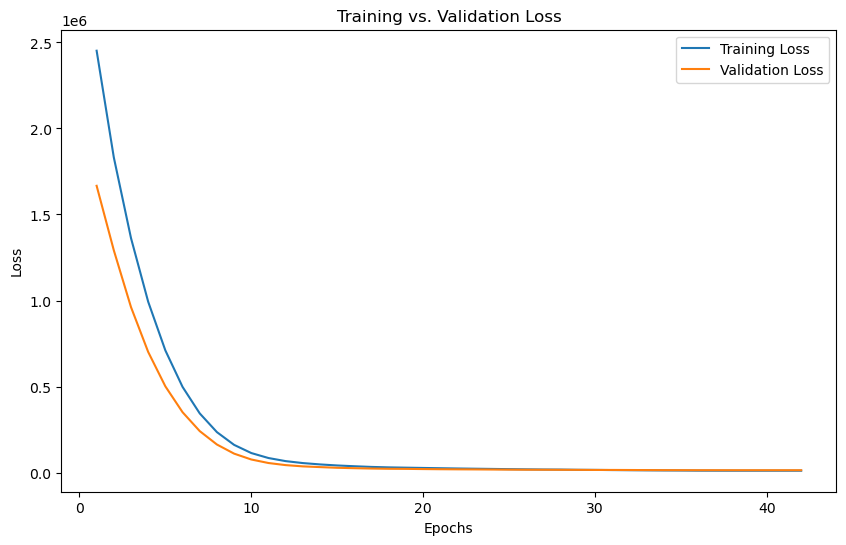

In [ ]:
epochs_range = range(1, len(train_losses) + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label="Training Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()

### Model Evaluation

In [ ]:
best_model = MultiOmicsTransformer(input_df.shape[1], target_df.shape[1], d_model=2048, nhead=4, num_transformer_layers=2, dropout=0.2)
best_model.load_state_dict(torch.load('best_model.pth', weights_only=True))
best_model.to("cpu")
best_model.eval()

In [ ]:
targets, predictions, gene_metrics = evaluate_model(best_model, test_loader, target_df.columns)

In [ ]:
print(f"Test MSE: {gene_metrics['MSE'].mean():.4f}")
print(f"Test MAE: {gene_metrics['MAE'].mean():.4f}")
print(f"Test R^2: {gene_metrics['R2'].mean():.4f}")

Test MSE: 0.1530
Test MAE: 0.2899
Test R^2: 0.5948


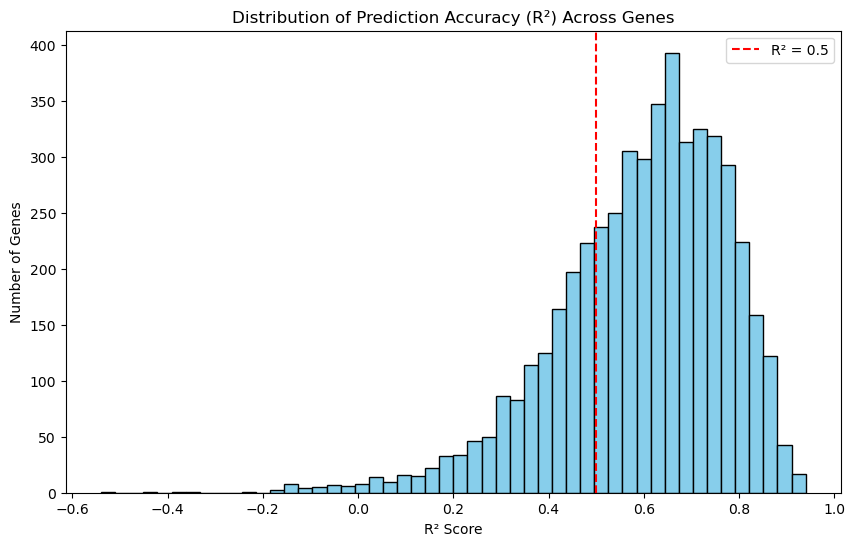

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(gene_metrics['R2'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('R² Score')
plt.ylabel('Number of Genes')
plt.title('Distribution of Prediction Accuracy (R²) Across Genes')
plt.axvline(x=0.5, color='red', linestyle='--', label='R² = 0.5')
plt.legend()
plt.show()

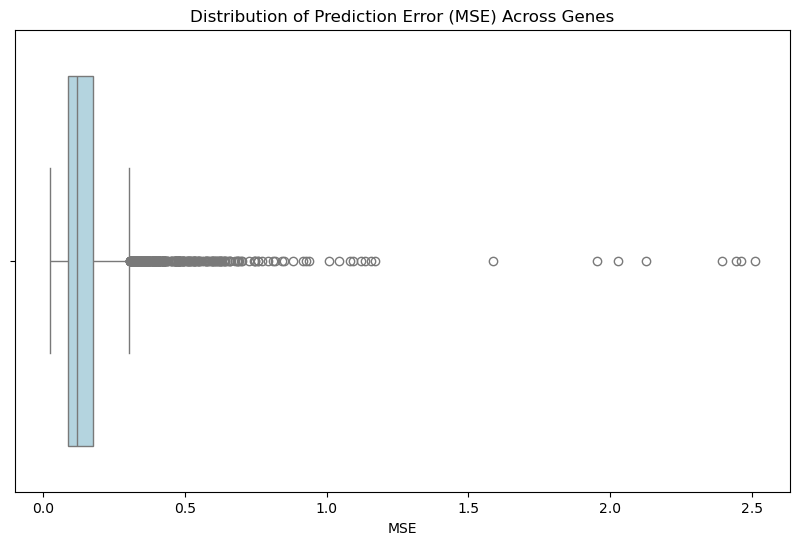

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=gene_metrics, x='MSE', orient='h', color='lightblue')
plt.xlabel('MSE')
plt.title('Distribution of Prediction Error (MSE) Across Genes')
plt.show()

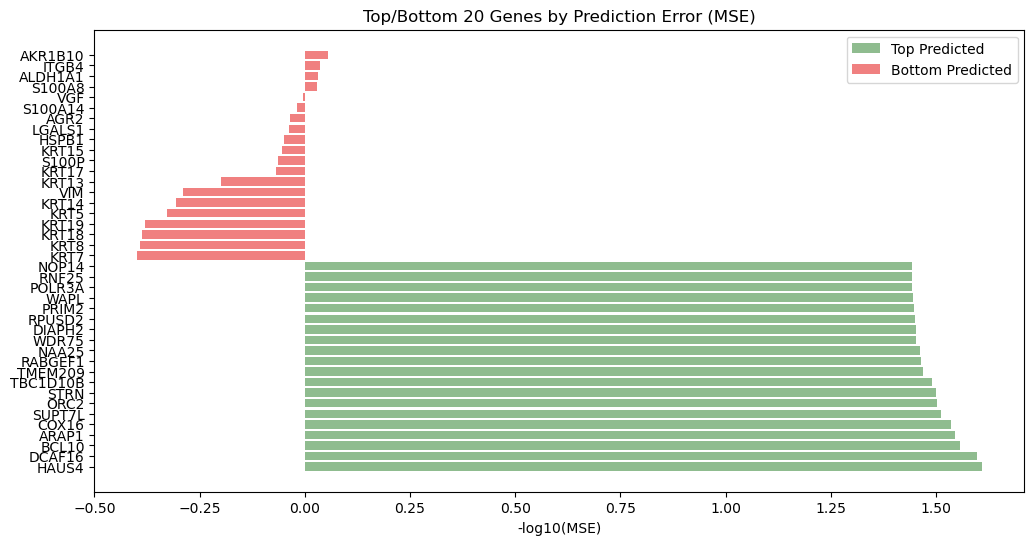

In [ ]:
top_20 = gene_metrics.nsmallest(20, 'MSE')
bottom_20 = gene_metrics.nlargest(20, 'MSE')

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(top_20['Gene'], -np.log10(top_20['MSE']), color='darkseagreen', label='Top Predicted')
ax.barh(bottom_20['Gene'], -np.log10(bottom_20['MSE']), color='lightcoral', label='Bottom Predicted')
ax.set_xlabel('-log10(MSE)')
ax.set_title('Top/Bottom 20 Genes by Prediction Error (MSE)')
ax.legend()
plt.show()

In [ ]:
def plot_gene_predictions(gene_name):
    gene_idx = target_df.columns.get_loc(gene_name)
    plt.figure(figsize=(8, 6))
    plt.scatter(targets[:, gene_idx], predictions[:, gene_idx], alpha=0.6)
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'r--')
    plt.xlabel('True Expression')
    plt.ylabel('Predicted Expression')
    plt.title(f'Gene: {gene_name}\nMSE={gene_metrics[gene_metrics["Gene"] == gene_name]["MSE"].values[0]:.3f}, R²={gene_metrics[gene_metrics["Gene"] == gene_name]["R2"].values[0]:.3f}')
    plt.show()

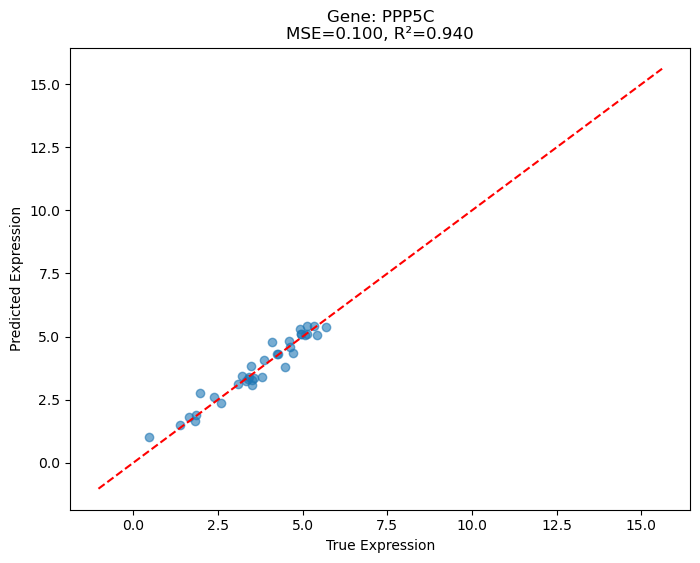

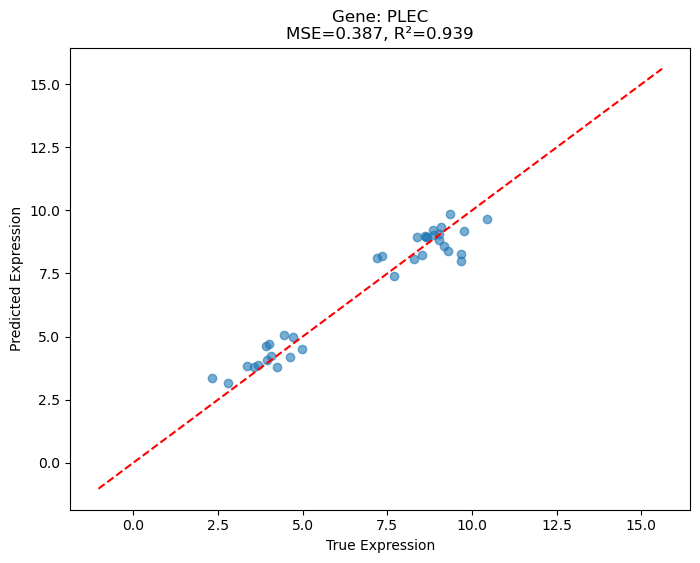

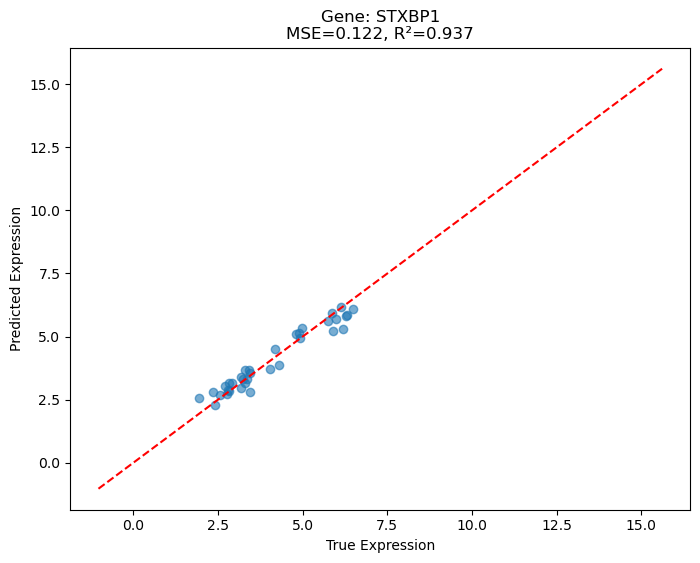

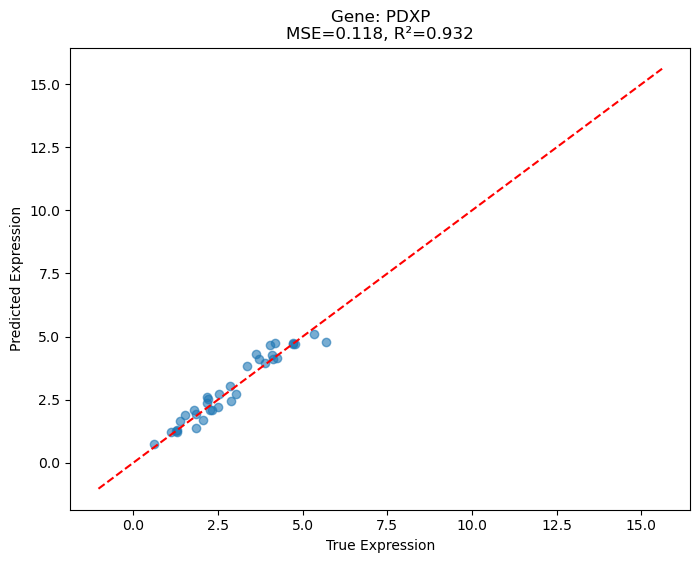

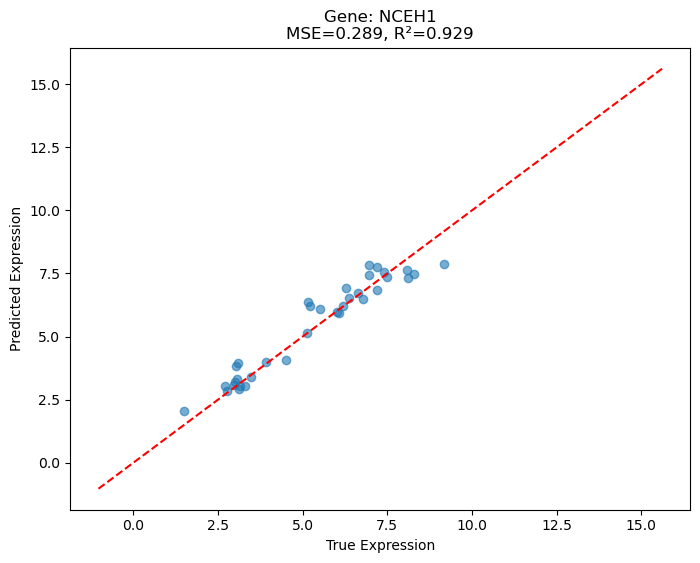

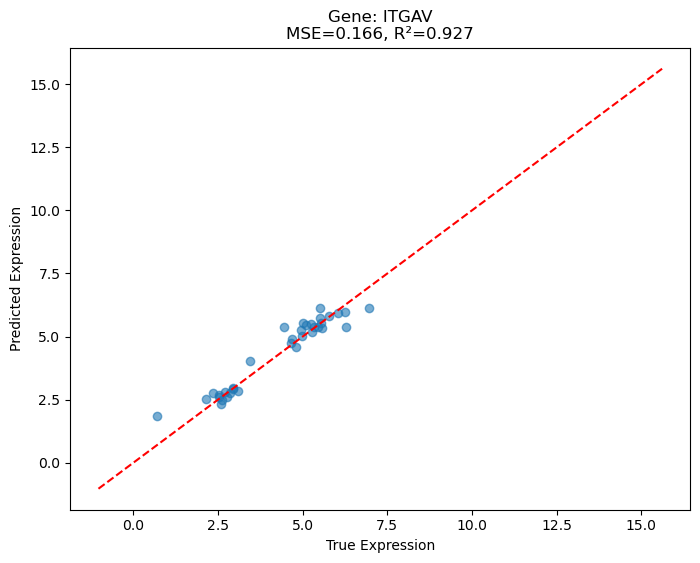

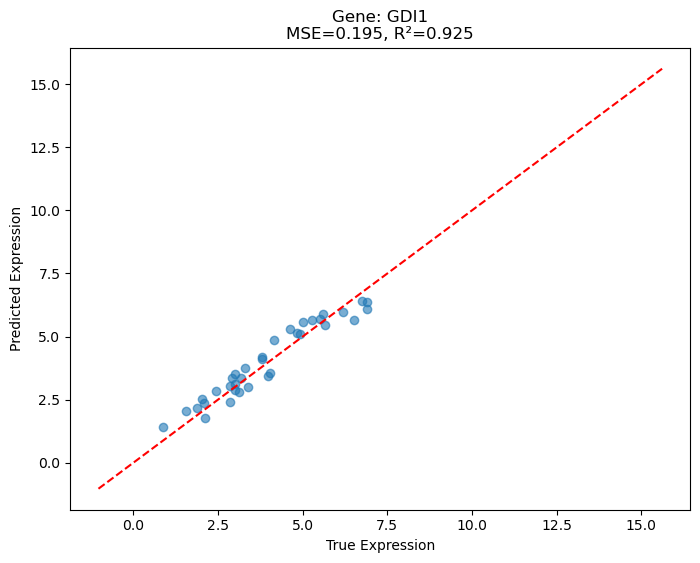

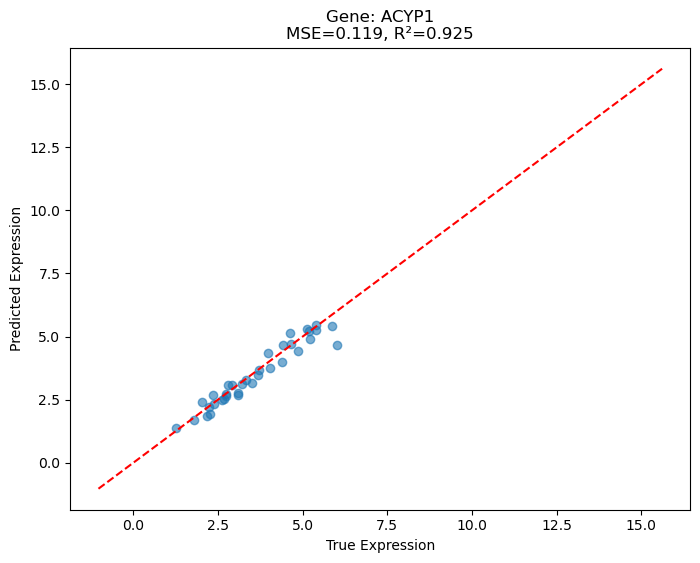

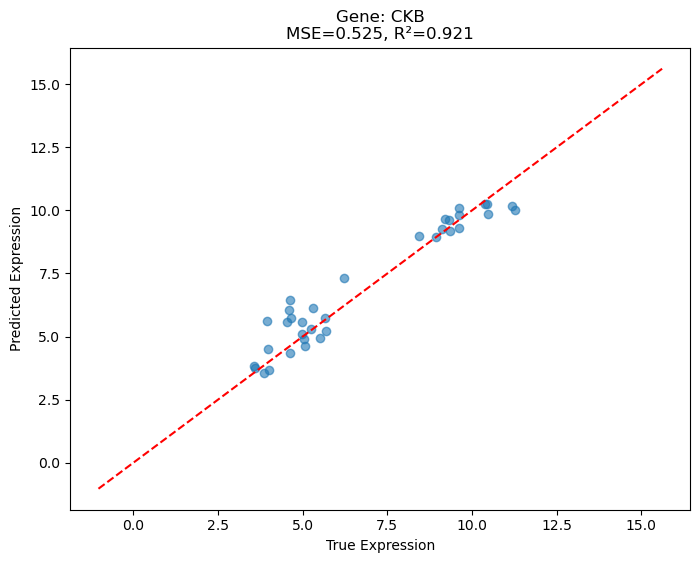

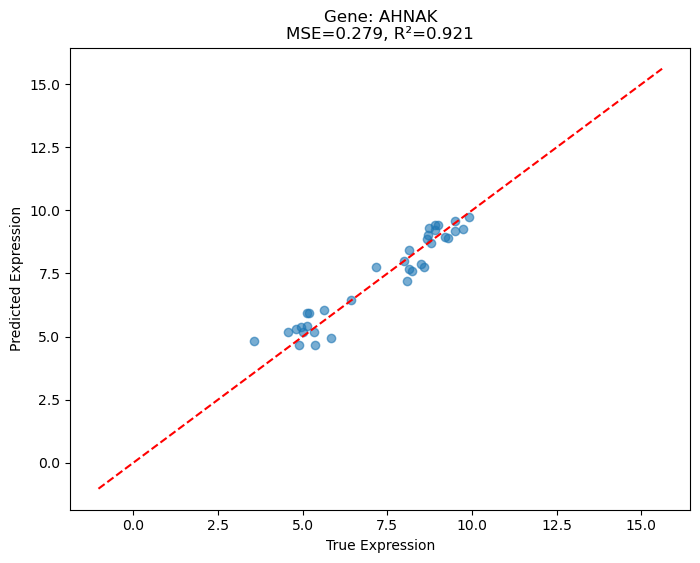

In [ ]:
for gene in gene_metrics.nlargest(10, 'R2').head(10)['Gene'].tolist():
    plot_gene_predictions(gene) 

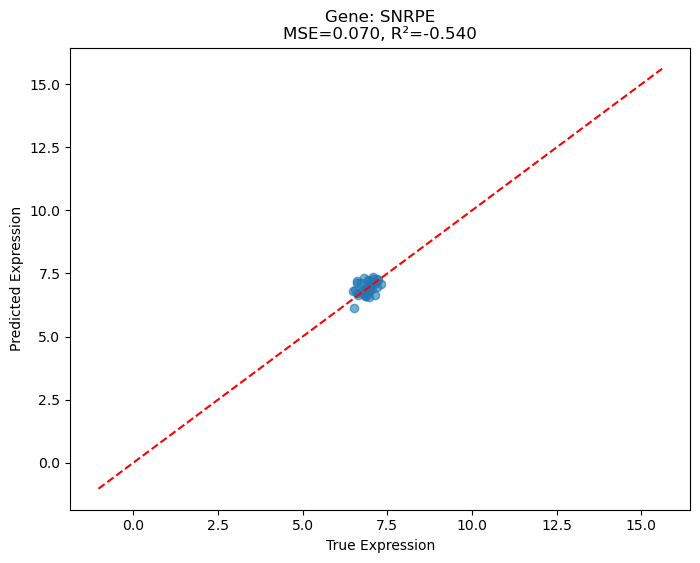

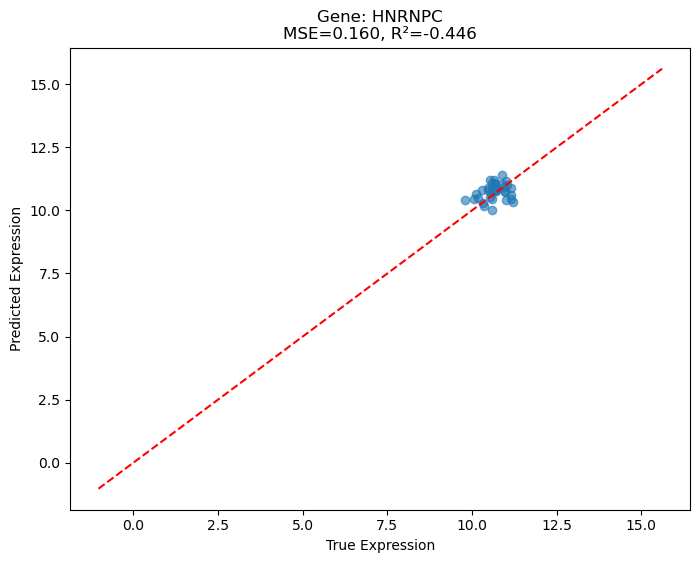

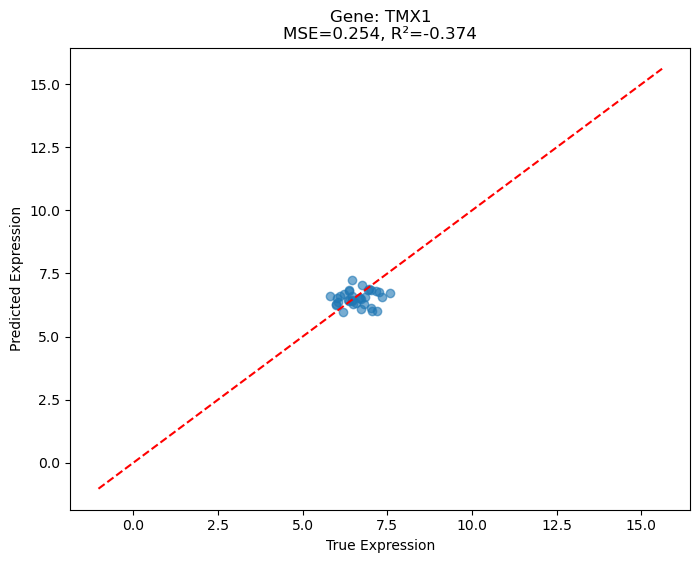

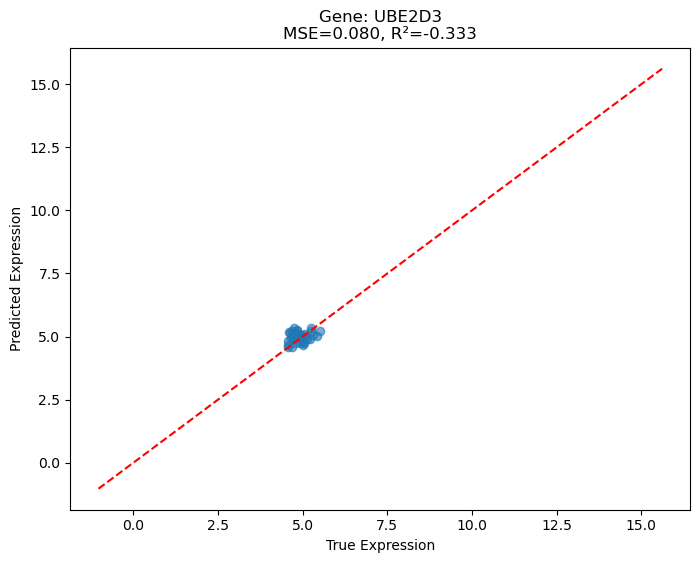

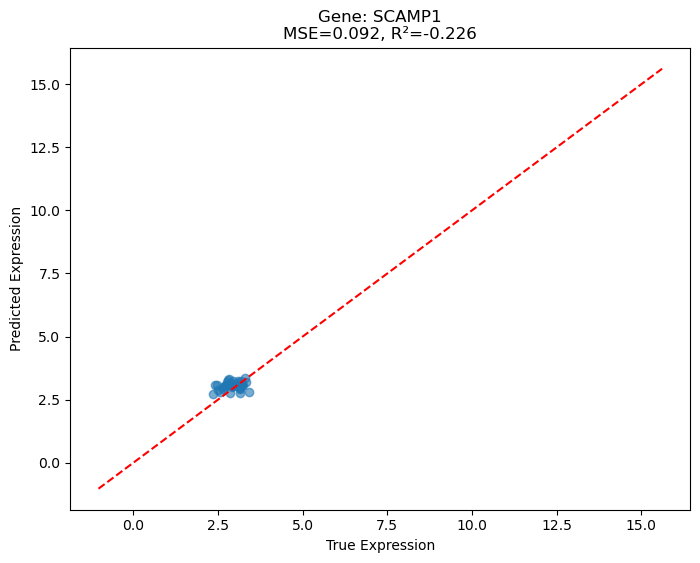

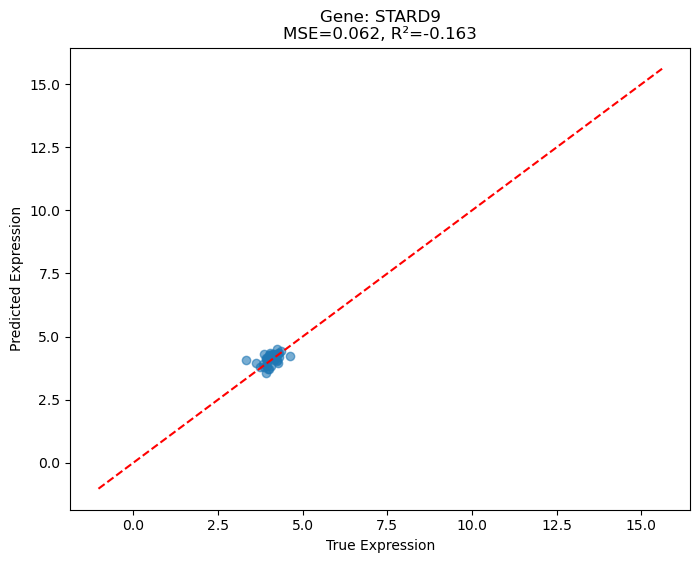

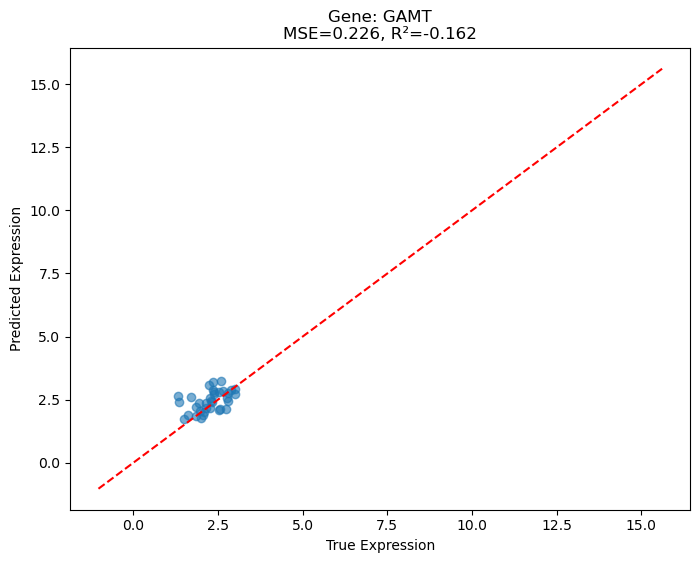

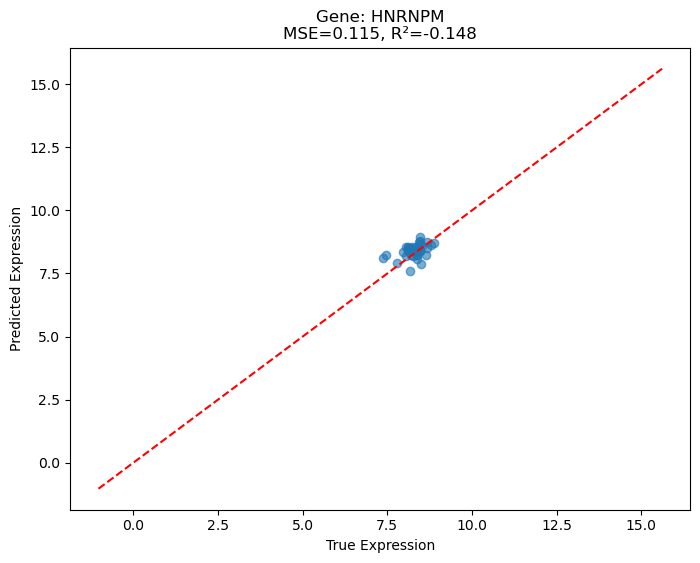

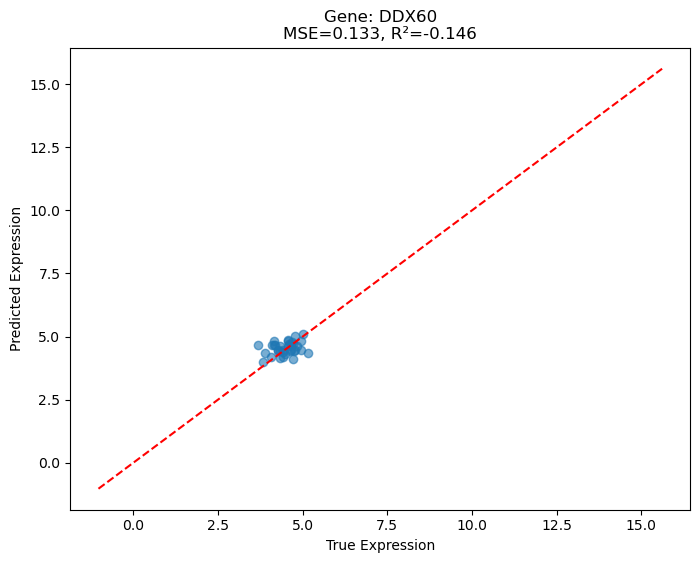

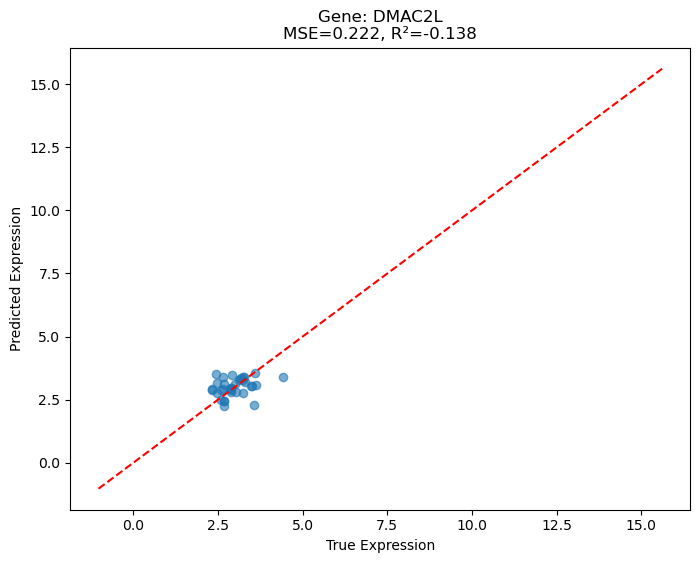

In [ ]:
for gene in gene_metrics.nsmallest(10, 'R2').head(10)['Gene'].tolist():
    plot_gene_predictions(gene)  

In [ ]:
gene_performance_sorted = gene_metrics.sort_values(
    by=["R2", "MSE"], 
    ascending=[False, True]
)
print("Top 10 Genes (High R² + Low MSE):")
display(gene_performance_sorted.head(10))

Top 10 Genes (High R² + Low MSE):


,Gene,MSE,MAE,R2,True_Variance
3240,PPP5C,0.099905,0.240124,0.940000,1.665095
3095,PLEC,0.387234,0.512215,0.939494,6.399889
4210,STXBP1,0.122015,0.282318,0.936965,1.935663
2992,PDXP,0.117891,0.267986,0.932491,1.746303
2600,NCEH1,0.288860,0.409279,0.928753,4.054329
1985,ITGAV,0.166233,0.291055,0.926757,2.269613
1555,GDI1,0.195298,0.401867,0.924773,2.596132
82,ACYP1,0.119280,0.251889,0.924748,1.585071
743,CKB,0.524795,0.550693,0.921400,6.676748
124,AHNAK,0.278686,0.447462,0.921306,3.541381


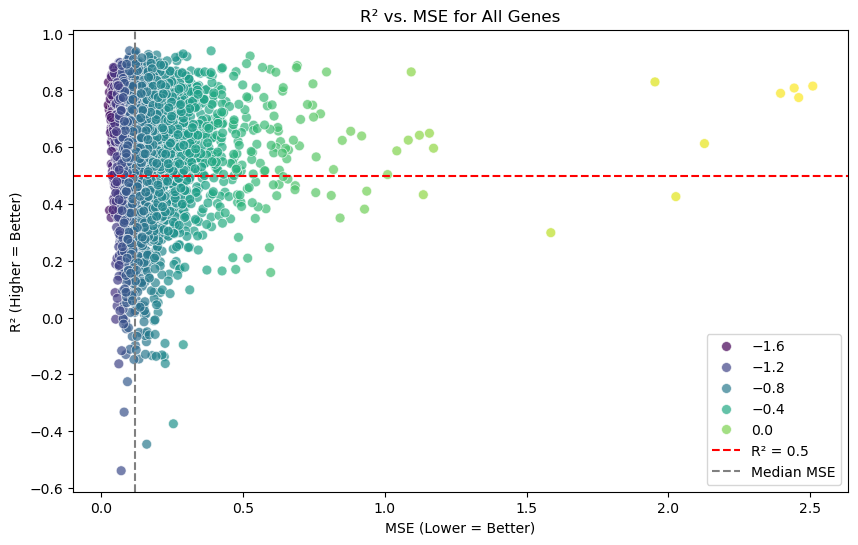

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=gene_metrics,
    x="MSE",
    y="R2",
    hue=np.log10(gene_metrics["MSE"]),  
    palette="viridis",
    alpha=0.7,
    s=50
)
plt.axhline(y=0.5, color="red", linestyle="--", label="R² = 0.5")  
plt.axvline(x=np.median(gene_metrics["MSE"]), color="grey", linestyle="--", label="Median MSE")
plt.xlabel("MSE (Lower = Better)")
plt.ylabel("R² (Higher = Better)")
plt.title("R² vs. MSE for All Genes")
plt.legend()
plt.show()